# Communes en non conformité


## Contexte :

- Quelles sont les communes avec le plus de non conformités dans l'année VS le moins

Choses à faire :


- Représenter trois types de situations liées à la conformité: C, NC0 et NC1 (cf <https://outline.services.dataforgood.fr/doc/espace-de-travail-data-analysts-Q3VWrKUd2g>)

- Répartition géographique de ces situations à l'échelle de la commune

- Comparer l’année 2024 avec les précédentes, jusqu’à 2020 inclue (évolution du nombre de situations NC, évolution de la répartition géographique etc)


Comment valider :
- faire une pull request depuis votre fork vers le main du repo github du projet (<<<https://github.com/dataforgoodfr/13_pollution_eau>>>)


## Partie Code et analyse

In [1]:
# importation des packages
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# importation des données
con = duckdb.connect(
    database=r"C:\Users\yacin\OneDrive\Documents\GitHub\13_pollution_eau\data.duckdb",
    read_only=True,
)

AttributeError: module 'duckdb' has no attribute 'connect'

In [ ]:
# Lister les tables disponibles dans la base duckdb
tables = con.execute(
    "SELECT table_name FROM information_schema.tables WHERE table_schema = 'main';"
).fetchall()
tables

[('edc_communes',), ('edc_prelevements',), ('edc_resultats',)]

On pocède trois tables dans notre base de données 
- edc_communes → informations sur les communes ;
- edc_prelevements → les prélèvements d'eau ;
- edc_resultats → les résultats des .

#### Consultation des colones pour chaques table

In [ ]:
tables = ["edc_communes", "edc_prelevements", "edc_resultats"]

for table in tables:
    print(f"Colonnes de {table} :")
    columns = con.execute(f"DESCRIBE {table};").fetchall()
    for col in columns:
        print(col)
    print("\n" + "-" * 50 + "\n")


Colonnes de edc_communes :
('inseecommune', 'VARCHAR', 'YES', None, None, None)
('nomcommune', 'VARCHAR', 'YES', None, None, None)
('quartier', 'VARCHAR', 'YES', None, None, None)
('cdreseau', 'VARCHAR', 'YES', None, None, None)
('nomreseau', 'VARCHAR', 'YES', None, None, None)
('debutalim', 'DATE', 'YES', None, None, None)
('de_partition', 'INTEGER', 'YES', None, None, None)
('de_ingestion_date', 'DATE', 'YES', None, None, None)

--------------------------------------------------

Colonnes de edc_prelevements :
('cddept', 'VARCHAR', 'YES', None, None, None)
('cdreseau', 'VARCHAR', 'YES', None, None, None)
('inseecommuneprinc', 'VARCHAR', 'YES', None, None, None)
('nomcommuneprinc', 'VARCHAR', 'YES', None, None, None)
('cdreseauamont', 'VARCHAR', 'YES', None, None, None)
('nomreseauamont', 'VARCHAR', 'YES', None, None, None)
('pourcentdebit', 'VARCHAR', 'YES', None, None, None)
('referenceprel', 'VARCHAR', 'YES', None, None, None)
('dateprel', 'DATE', 'YES', None, None, None)
('heurepr

# EDA

## Comprendre la Table edc_prelevements

Vérifier les Colonnes et un Échantillon des Données

In [ ]:
# Voir les premières lignes de la table edc_prelevements
df_prelevements = con.execute("SELECT * FROM edc_prelevements;").fetchdf()
df_prelevements


,cddept,cdreseau,inseecommuneprinc,nomcommuneprinc,cdreseauamont,nomreseauamont,pourcentdebit,referenceprel,dateprel,heureprel,conclusionprel,ugelib,distrlib,moalib,plvconformitebacterio,plvconformitechimique,plvconformitereferencebact,plvconformitereferencechim,de_partition,de_ingestion_date
0,001,001000003,01007,AMBRONAY,None,None,None,00100139034,2024-01-23,11h27,Eau d'alimentation conforme aux limites de qua...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,N,C,2024,2025-02-12
1,001,001000003,01007,AMBRONAY,None,None,None,00100139393,2024-02-13,12h49,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024,2025-02-12
2,001,001000003,01007,AMBRONAY,001001304,TTP (CLG) AMBRONAY,100 %,00100139969,2024-03-13,10h46,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024,2025-02-12
3,001,001000003,01007,AMBRONAY,None,None,None,00100140209,2024-04-05,07h27,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024,2025-02-12
4,001,001000003,01007,AMBRONAY,None,None,None,00100140543,2024-05-13,12h43,Eau d'alimentation conforme aux exigences de q...,SYND. EAUX REGION D'AMBERIEU-EN-B,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,SERA - SYNDICAT DES EAUX DE LA REGION D'AMBERI...,C,C,C,C,2024,2025-02-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416123,976,976003554,97615,PAMANDZI,976000056,UP PAMANDZI,100 %,97600031949,2024-07-22,10h22,Eau d'alimentation conforme aux exigences de q...,MAYOTTE,SMAE,LES EAUX DE MAYOTTE,C,C,C,C,2024,2025-02-12
416124,976,976003554,97615,PAMANDZI,None,None,None,97600031996,2024-07-30,09h52,Eau d'alimentation conforme aux exigences de q...,MAYOTTE,SMAE,LES EAUX DE MAYOTTE,C,C,C,C,2024,2025-02-12
416125,976,976003554,97615,PAMANDZI,None,None,None,97600031997,2024-08-06,09h10,Eau d'alimentation conforme aux exigences de q...,MAYOTTE,SMAE,LES EAUX DE MAYOTTE,C,C,C,C,2024,2025-02-12
416126,976,976003554,97615,PAMANDZI,976000056,UP PAMANDZI,100 %,97600032142,2024-09-10,09h20,Eau d'alimentation non conforme aux limites de...,MAYOTTE,SMAE,LES EAUX DE MAYOTTE,N,C,C,C,2024,2025-02-12


Les colonnes sont :

- cddept : Code du département
- cdreseau : Code du réseau
- inseecommuneprinc : Code INSEE de la commune principale
- nomcommuneprinc : Nom de la commune principale
- cdreseauamont : Code du réseau amont
- nomreseauamont : Nom du réseau amont
- pourcentdebit : Pourcentage du débit (ou de la quantité mesurée)
- referenceprel : Référence du prélèvement
- dateprel : Date du prélèvement
- heureprel : Heure du prélèvement
- conclusionprel : Conclusion du prélèvement (conforme ou non conforme, etc.)
- ugelib : Libellé de l’unité de gestion
- distrlib : Libellé du distributeur
- moalib : Libellé de l'opérateur
- plvconformitebacterio : Conformité en termes de critères bactériologiques
- plvconformitechimique : Conformité en termes de critères chimiques
- plvconformitereferencebact : Conformité des références bactériologiques
- plvconformitereferencechim : Conformité des références chimiques
- de_partition : (Probablement une référence à la partition des données ou une unité temporelle)
- de_ingestion_date : Date d’ingestion des données

 Points à analyser :
- Conformité : Observer le taux de conformité des prélèvements, notamment pour les critères bactériologiques et chimiques.
- Tendances temporelles : Analyser les prélèvements au fil du temps pour identifier des anomalies saisonnières ou des périodes spécifiques.
- Répartition géographique : Étudier les prélèvements par commune ou réseau.
- Débit : Si des pourcentages de débit sont présents, analyser leur évolution pour évaluer l'impact sur la qualité de l'eau.

### 1. Répartition des Non-Conformités (C, NC0, NC1)

D'abord, nous devons bien comprendre les trois types de situations de conformité :

C : Conforme
- NC0 : Non-conforme mais pas grave
- NC1 : Non-conforme avec des conséquences plus graves
- Étape à suivre :

- Analyser la colonne de conformité (qui pourrait correspondre à plvconformitebacterio et plvconformitechimique ou une autre colonne).
- Créer une classification des situations en "C", "NC0" et "NC1" selon les valeurs présentes.
- Compter le nombre d’occurrences de chaque situation pour chaque commune.

2. Répartition Géographique de ces Situations
- Une fois les catégories établies, il faudra les visualiser sur une carte ou par des graphiques, en représentant les communes avec le plus grand nombre de non-conformités (NC0, NC1), et celles avec le moins.

Étape à suivre :

- Identifier les communes avec un nombre élevé ou faible de non-conformités.
- Utiliser un graphique de type bar chart ou une carte géographique (en fonction de la disponibilité des données géographiques).
3. Évolution des Non-Conformités par Année (2024 vs 2020-2023)
- Analyser l’évolution des non-conformités pour les années passées.

Étape à suivre :

- Extraire les données pour chaque année, en faisant attention aux dates de prélèvement.
- Calculer le nombre de situations "NC" (toutes catégories) chaque année.
- Comparer cette évolution, en mettant l'accent sur les tendances par année et par commune.


Étape 1 : Préparation des données
Nous allons tout d'abord analyser les types de conformité dans les colonnes associées, puis les classer en C, NC0, et NC1. Si les colonnes de conformité se trouvent dans plvconformitebacterio, plvconformitechimique, et potentiellement d'autres colonnes, il faut vérifier et regrouper ces informations.

- Nous allons :

Identifier les colonnes de conformité.
- Créer des catégories en fonction des valeurs de conformité.
- Calculer le nombre de C, NC0, et NC1 pour chaque commune.


1) Vérifier les valeurs de conformité (plvconformitebacterio, plvconformitechimique)

In [ ]:
con.execute("""
SELECT 
    plvconformitebacterio, 
    plvconformitechimique, 
    COUNT(*) AS nombre
FROM edc_prelevements
GROUP BY plvconformitebacterio, plvconformitechimique;
""").fetchdf()



,plvconformitebacterio,plvconformitechimique,nombre
0,None,None,3
1,C,C,369199
2,C,D,503
3,C,N,8785
4,C,S,101
5,N,C,5504
6,N,D,2
7,N,N,146
8,S,C,25664
9,S,D,294


- On observe que la conformité des prélèvements (plvconformitebacterio, plvconformitechimique) prend plusieurs valeurs :

* C : Conforme
* N : Non conforme
* D : Données douteuses
* S : Sous surveillance
None : Valeurs manquantes
- Il y a une grande majorité de prélèvements conformes (C, C avec 369 199 occurrences), mais aussi des cas de non-conformité (C, N et N, C), ainsi que des prélèvements sous surveillance ou douteux.

2) Ajouter la classification (C, NC0, NC1)
- On crée une nouvelle table avec un statut de conformité clair

In [ ]:
# Classification des  statuts avec pandas 
def classify_conformity(row):
    if pd.isna(row["plvconformitebacterio"]) or pd.isna(row["plvconformitechimique"]):
        return "NC1"
    elif row["plvconformitebacterio"] == "C" and row["plvconformitechimique"] == "C":
        return "C"
    elif row["plvconformitebacterio"] in ["N", "D", "S"] or row["plvconformitechimique"] in ["N", "D", "S"]:
        return "NC0"
    else:
        return "NC1"

# Appliquer la classification
df_prelevements["statut_conformite"] = df_prelevements.apply(classify_conformity, axis=1)

# Vérifier les résultats
df_prelevements["statut_conformite"].value_counts()


statut_conformite
C      369199
NC0     46926
NC1         3
Name: count, dtype: int64

2) Nombre de non-conformités par commune

In [ ]:
df_communes = (
    df_prelevements.groupby("nomcommuneprinc")
    .agg(
        total_prelevements=("statut_conformite", "count"),
        NC0=("statut_conformite", lambda x: (x == "NC0").sum()),
        NC1=("statut_conformite", lambda x: (x == "NC1").sum()),
    )
    .reset_index()
    .sort_values(by=["NC0", "NC1"], ascending=False)
)

# Top 10 communes avec le plus de non-conformités
print(df_communes.head(10))

# Top 10 communes avec le moins de non-conformités
print(df_communes.tail(10))


         nomcommuneprinc  total_prelevements  NC0  NC1
17303      MERY-SUR-OISE                1570  381    0
17110          MENE (LE)                 346  197    0
1575             AUXERRE                 481  142    0
729              ANTIBES                 308  136    1
27663  SENNECEY-LE-GRAND                 140  131    0
337             ALLASSAC                 155  128    0
16688          MARSEILLE               10855  128    0
16021              MADRE                 122  121    0
13248         HORPS (LE)                 125  120    0
12437         GROS-MORNE                 188  115    0
      nomcommuneprinc  total_prelevements  NC0  NC1
32088         ZILLING                   1    0    0
32089      ZILLISHEIM                   8    0    0
32091     ZIMMERSHEIM                  30    0    0
32092         ZIMMING                   1    0    0
32093        ZINCOURT                   1    0    0
32096        ZOMMANGE                   1    0    0
32098          ZOTEUX          

3) Évolution des non-conformités de 2020 à 2024 

In [ ]:
df_prelevements["annee"] = pd.to_datetime(df_prelevements["dateprel"]).dt.year

df_evolution = (
    df_prelevements.groupby("annee")
    .agg(
        total_prelevements=("statut_conformite", "count"),
        conformes=("statut_conformite", lambda x: (x == "C").sum()),
        NC0=("statut_conformite", lambda x: (x == "NC0").sum()),
        NC1=("statut_conformite", lambda x: (x == "NC1").sum()),
    )
    .reset_index()
    .query("annee >= 2020")  # Filtrer sur les années 2020-2024
)

print(df_evolution)


   annee  total_prelevements  conformes    NC0  NC1
0   2024              416128     369199  46926    3


4) Visualisation de l’évolution des non-conformités 

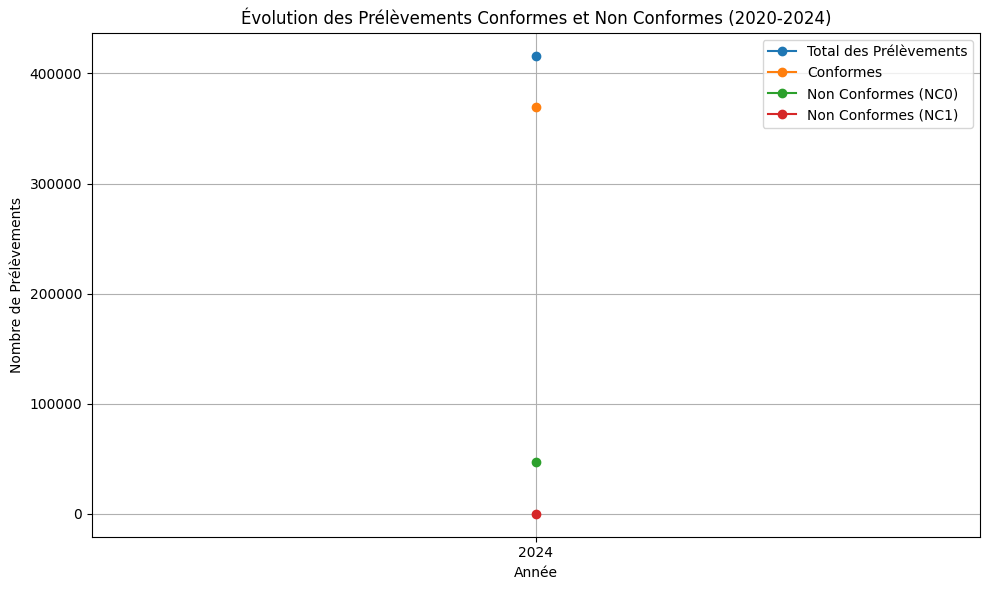

In [ ]:
import matplotlib.pyplot as plt

# Graphique de l'évolution des non-conformités
plt.figure(figsize=(10, 6))

# Tracer les courbes
plt.plot(df_evolution['annee'], df_evolution['total_prelevements'], label='Total des Prélèvements', marker='o')
plt.plot(df_evolution['annee'], df_evolution['conformes'], label='Conformes', marker='o')
plt.plot(df_evolution['annee'], df_evolution['NC0'], label='Non Conformes (NC0)', marker='o')
plt.plot(df_evolution['annee'], df_evolution['NC1'], label='Non Conformes (NC1)', marker='o')

# Ajouter des étiquettes et une légende
plt.title('Évolution des Prélèvements Conformes et Non Conformes (2020-2024)')
plt.xlabel('Année')
plt.ylabel('Nombre de Prélèvements')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.xticks(df_evolution['annee'])  # Assurer que toutes les années sont affichées
plt.tight_layout()
plt.show()

